In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Dense, Input

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
# LSTM for air pollution problem with regression framing
import numpy
import matplotlib.pyplot as plt
import math
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung


In [ ]:
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [ ]:
# fix random seed for reproducibility
np.random.seed(7)

In [ ]:
df = pd.read_csv('data/pollution_new.csv', index_col = 0)
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
1/2/2010 0:00,129,-16,-4.0,1020.0,SE,1.79,0,0
1/2/2010 1:00,148,-15,-4.0,1020.0,SE,2.68,0,0
1/2/2010 2:00,159,-11,-5.0,1021.0,SE,3.57,0,0
1/2/2010 3:00,181,-7,-5.0,1022.0,SE,5.36,1,0
1/2/2010 4:00,138,-7,-5.0,1022.0,SE,6.25,2,0


In [ ]:
# convert an array of values into a dataset matrix
# # look_back là số ngày nó nhìn lại
# vd: look_back = 1 nghĩa là hôm nay nhìn lại từ hqua, hqua nhìn lại từ hôm kia, ...
def create_dataset(dataset, look_back=1): 
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
	#t
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
	#t+1
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)


In [ ]:
dataset = df[['pollution']]
dataset = dataset.values.astype('float32')

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# split train - test 
# data lấy theo giờ với 4 năm đầu cho train (4 năm đầu cho phần train)
train_size = 365*24*4  

train, test = dataset[0:train_size, :], dataset[train_size:, :]

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back)))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


**Giải thích cách tính tham số**
- lstm (LSTM) = [(num_units + input_dim + 1) x num_units] x 4 = [(32 + 1 + 1) x 32] x 4 = 4352
- dense = ((current layer n x previous layer n) + bias) = 1 x 32 + 1 = 33


In [ ]:
from keras.callbacks import EarlyStopping


In [ ]:
early_stopping = EarlyStopping(min_delta = 0.0001, patience = 20, restore_best_weights = True)

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, validation_data=(testX, testY), 
                    epochs=100, 
                    batch_size=32,
                    verbose=0,
                    callbacks = [early_stopping])

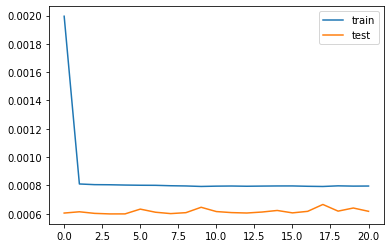

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
trainY[0][:5]

array([148.00000139, 158.99999549, 180.9999985 , 137.99999329,
       108.99999942])

In [ ]:
trainPredict[:5]

array([[124.2335 ],
       [142.21841],
       [152.67332],
       [173.67467],
       [132.74095]], dtype=float32)

In [ ]:
# calculate root mean squared error
train_rmse = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f RMSE' % (train_rmse))
test_rmse = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f RMSE' % (test_rmse))


Train RMSE: 28.16 RMSE
Test RMSE: 24.44 RMSE


In [ ]:
df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000
mean,94.015388,1.829037,12.459394,1016.446905,23.889148,0.052764,0.195027
std,92.252497,14.429079,12.193300,10.271186,50.011647,0.760591,1.416263
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.500000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [ ]:
'''
với std = 92.252497	và mean = 94.015388 => tạm chấp nhận model
'''

'\nvới std = 92.252497\tvà mean = 94.015388 => tạm chấp nhận model\n'

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


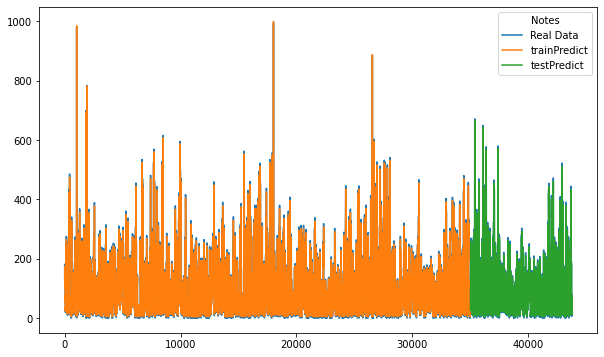

In [ ]:
%matplotlib inline

# plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(dataset), label='Real Data')
plt.plot(trainPredictPlot, label='trainPredict')
plt.plot(testPredictPlot, label='testPredict')
plt.legend(title="Notes")
plt.show()


In [ ]:
# ws = {}
# for layer in model.layers:
#   ws[layer.name] = layer.get_weights()
# ws

In [ ]:
# x_new = 8 => next time = ?
x_new = scaler.transform([[8]])
x_new = numpy.reshape(x_new, (1, 1, 1))
y_new = model.predict(x_new)
y_new = scaler.inverse_transform(y_new)
y_new

array([[12.027622]], dtype=float32)